<hr style="height:10px"> 
 
<div class='container2'>
	<div style='padding: 0 7em 2em 0em;'>
	<h1>Trabalho de Inteligência Artificial</h1>
    <h3> <a href="https://github.com/amandakouchi">Amanda Kouchi</a> &#x25CF; <a href="https://github.com/biarog">Beatriz Rogers</a> &#x25CF; <a href="https://github.com/matteoavan">Matteo Savan</a> &#x25CF; <a href="https://github.com/RaulYKomai">Raul Y. Komai</a>
	</div>
</div>


 <hr style="height:5px"> 

    
<h2>Algoritmos e Avaliação em Agrupamento</h2>

## Introdução

Neste *notebook*, exploramos três métodos de agrupamento: K-Médias, Single-Link e Complete-Link; e o Índice Rand. Cada um desses algoritmos, todos implementados em Python, aplica uma abordagem diferente de organização de dados em grupos, o que influencia tanto na forma como os clusters são definidos quanto na interpretação que podemos ter dos resultados obtidos. 
	
O objetivo desse projeto, referente à matéria de Inteligência Artificial da professora Drª Katti Faceli, é construir e aplicar os algoritmos aos datasets fornecidos, avaliando a qualidade das partições resultantes por meio do Índice Rand Ajustado, comparando-os com as partições reais.

---

## Recursos Necessários

Para este *notebook*, deve ser utilizado o `Python 3.6` ou superior com as seguintes bibliotecas externas, que deverão ser instaladas:

* [`matplotlib`](versão 3.9.2 ou superior): construção e exibição de gráficos variados
* [`numpy`](versão 2.1 ou superior): manipulação de dados em formato de vetores e matrizes
* [`pandas`](versão 2.2.2 ou superior): manipulação de dados em formato de tabelas
* [`sklearn`](versão x.x ou superior): completar
* [`seaborn`]versão x.x ou superior): completar

A biblioteca [`os`](https://docs.python.org/3/library/os.html), para realizar tarefas específicas ao Sistema Operacional, também será utilizada. Por fazer parte da [Biblioteca Padrão de Python](https://docs.python.org/pt-br/3/library/), sua instalação não é necessária.

Serão utilizados também os conjuntos de dados disponibilizados junto com este *notebook*, que se encontram no diretório `datasets`, em formato de arquivo `.txt`.

In [46]:
## Imports
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import cluster 
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import seaborn as sns
import sys

%matplotlib inline

DATASETS_DIR = 'datasets'

---
## Funções Auxiliares

In [47]:
## Função auxiliar para carregar dados
def load_dataset(dataset_name):
    dataset = pd.read_csv(os.path.join(DATASETS_DIR, dataset_name+'.txt'), sep='\t', index_col = 0)
    return dataset

In [48]:
## Funcao para definir cores

def colorize(data):
    color_palette = ['#910101', '#036CD7', '#078F8F', '#000000', '#FDFD6F', '#B16FFD', '#22FF25',
                     '#074752', '#8F4A00', '#FE6FB5', '#6BB6FE', '#DF6B00', '#48018D', '#FCB5DA']
    labels = np.unique(data)
    if len(labels) > len(color_palette):
        color_palette += ["#%06x" % c for c in np.random.randint(0, 0xFFFFFF, len(labels)-len(color_palette))]
    color_array = np.empty(data.shape, dtype=object)
    for label, color in zip(labels, color_palette):
        color_array[np.where(data==label)] = color
    return color_array

In [49]:
## Função auxiliar para plottar os dados de saída

def plot_multiple_partitions(dataset, cluster_labels, nrows, ncols, suptitle=None, subtitles=None):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(min(5*ncols, 12), 3*nrows), constrained_layout=True)
    ax = ax.flatten()
    for i, clusters in enumerate(cluster_labels):
        ax[i].scatter(dataset['d1'], dataset['d2'], s=10, c=colorize(clusters))
        if subtitles is not None:
            ax[i].set_title(subtitles[i])
        ax[i].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    plt.show()
## Função auxiliar para plottar os dados de entrada
def plot_entry_data(data) -> None:
    X = data[['d1', 'd2']]
    plt.scatter(X["d1"],X["d2"], c="red")
    plt.xlabel("d1")
    plt.ylabel("d2")
    plt.show()

In [50]:
## Função auxiliar para plottar os dados de entrada
def plot_entry_data(data) -> None:
    X = data[['d1', 'd2']]
    plt.scatter(X["d1"],X["d2"], c="red")
    plt.xlabel("d1")
    plt.ylabel("d2")
    plt.show()

In [51]:

## Funcao auxiliar para definir o dataframe apos a agregacao
def create_df(data, clusters):
    df = pd.DataFrame(data)
    df.columns = ["d1","d2"]
    df["cluster"] = clusters
    
    return df

In [52]:
## Função auxiliar para plottar após funcao de agregacao
def plot_grouped_data(df, n_clusters) -> None:
    cores = sns.color_palette()[0:n_clusters]
    df = df.sort_values("sample_label")
    sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["cluster"], palette=cores)
    plt.show()

In [53]:

def export_dataframe(df, n_group, n_arquivo, n_clusters) -> None :
    select = ['sample_label', 'cluster']
    select = [x for x in df.columns if x in select]
    export = df[select]
    export.to_csv(n_group + '' + n_arquivo + str(n_clusters) + '.csv')

---
## Dados Iniciais

Em seguida estão desenhados os dados originais que serão utilizados nos testes de todas as funções de agrupamento.

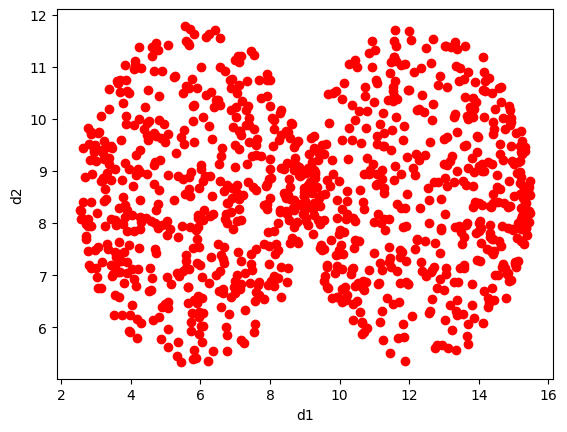

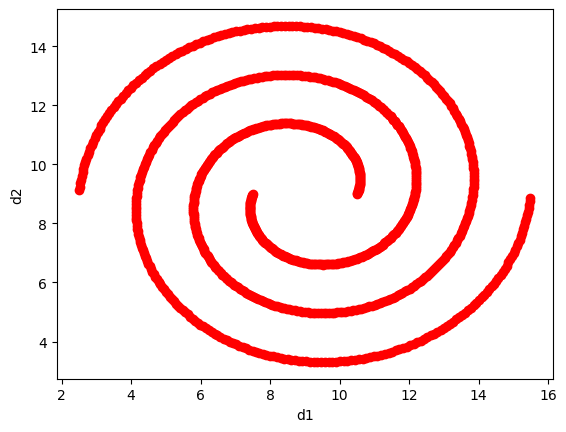

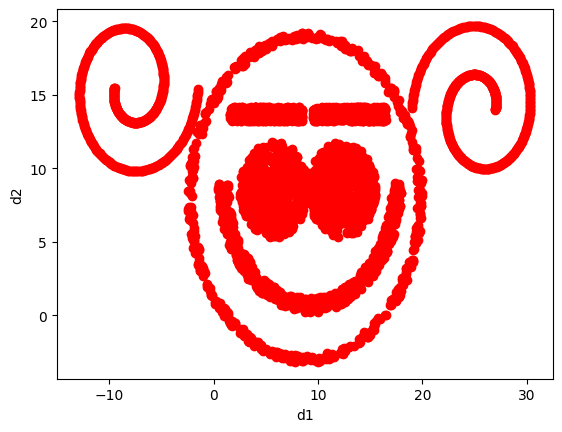

In [54]:

## Entrada das bases de dados
globs, spiral, monkey = load_dataset('c2ds3-2g'), load_dataset('c2ds1-2sp'), load_dataset('monkey')
dados = [globs, spiral, monkey]
plot_entry_data(data=dados[0])
plot_entry_data(data=dados[1])
plot_entry_data(data=dados[2])
plt.show()

---
## K-médias

O K-Médias busca minimizar a soma das distâncias quadradas entre os pontos de dados e o centróide do cluster ao qual pertencem. O algoritmo começa escolhendo k centróides iniciais, que podem ser selecionados aleatoriamente, e então itera entre atribuir cada ponto ao centróide mais próximo e recalcular os centróides dos clusters formados. O processo continua até que os centróides se estabilizem ou até que o número máximo de iterações seja atingido. 

O nosso algoritmo recebe como entrada um arquivo texto com o conjunto de dados, o número de clusters desejado e o número de iterações que o algoritmo deverá executar. A saída produzida é um arquivo com uma partição do conjunto de dados no mesmo formato que o da partição real.

In [55]:
## Função de distância
def distancia(a,b):
    return np.square(np.sum((a-b)**2)) 

In [56]:
## Entrada de dados
maxiter = 2

In [57]:
## Função de iniciar centróides
def initiate_centroids(k,dset):
    centroides = dset.sample(k)
    return centroides

## Iniciar centróides
X0 = dados[0][['d1', 'd2']]
X1 = dados[1][['d1', 'd2']]
X2 = dados[2][['d1', 'd2']]

In [66]:
## Atribuição de das amostras aos centróides
def centroid_assignation(dset, centroids):
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []

    for obs in range(n):
        # Calcular distâncias
        distances = np.array([])
        for centroid in range(k):
            err = distancia(centroids.iloc[centroid, :], dset.iloc[obs,:])
            distances = np.append(distances, err)

        # Pegar o centróide mais próximo
        nearest_centroid =  np.where(distances==np.amin(distances))[0].tolist()[0]

        # Adicionar os valores às suas listas correspondentes
        assignation.append(nearest_centroid)

    return assignation

In [67]:
## Função do K-médias
def kmeans(dset, k, maxiter):
    working_dset = dset.copy()
    
    centroids = initiate_centroids(k, dset)

    for i in range(maxiter):
        working_dset['centroid'] = centroid_assignation(working_dset, centroids) 
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

    working_dset['centroid'] = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], centroids

In [68]:
## Execução do K-médias
np.random.seed(86)
centroidsg = []
centroidsp = []
centroidsm = []
for i in range(2,13):
    if i <= 5:
        X0['centroid' + str(i)], centroidsg =  kmeans(X0[['d1','d2']], i, maxiter)
        X1['centroid' + str(i)], centroidsp =  kmeans(X1[['d1','d2']], i, maxiter)
    if i >= 5:
        X2['centroid' + str(i)], centroidsm =  kmeans(X2[['d1','d2']], i, maxiter)

In [69]:
## Plotar após k-médias
df0_kmeans = pd.DataFrame(X0)
df1_kmeans = pd.DataFrame(X1)
df2_kmeans = pd.DataFrame(X2)

def kmeans_plot(df, rangemin:int, rangemax:int): 
    for i in range(rangemin,rangemax):
        cores = sns.color_palette()[0:i]
        sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["centroid" + str(i)], palette=cores)
        plt.show() 

In [70]:
## Função auxiliar para exportar arquivos
def exportar(nome_arquivo, df, centroid):
    select_ = ['sample_label', centroid]
    select = [x for x in df.columns if x in select_]
    export = df[select]
    export.to_csv(nome_arquivo + '.csv')

In [71]:
## Exportar arquivos
for i in range(2,13):
    if i <= 5:
        exportar('Kmeans_glob'+str(i), df0_kmeans, 'centroid'+str(i))
        exportar('Kmeans_spiral'+str(i), df1_kmeans, 'centroid'+str(i))

    if i >= 5:
        exportar('Kmeans_monkee'+str(i), df2_kmeans, 'centroid'+str(i))

---
## Single-Link

O Single-Link é um algoritmo hierárquico que forma clusters. Inicialmente, cada  dado é tratado como um cluster individual. Após iterar, há união dos dois clusters mais próximos em cada etapa, onde a proximidade é determinada pela menor distância entre qualquer par de pontos nos dois clusters.

O nosso algoritmo recebe como entrada um arquivo texto com o conjunto de dados kMin e kMax (2 e 5, respectivamente). A saída produzida é um ou mais arquivos, cada um com uma partição do conjunto de dados.

In [63]:
## Função de Single Link
def single_link(data, n_clusters:int):
    m_distancias = distance_matrix(data.values, data.values, p=2)
    single = [-1]*len(m_distancias)
    total_clusters = len(m_distancias)
    counter:int = 0
    cluster_id:int = -1
    
    if total_clusters > n_clusters:      
        while(total_clusters > n_clusters): 
            n_menos1 = 0
            line:int = 0
            column:int = 0
            
            cluster:bool = True
            
            shortest_dist = np.min(m_distancias[m_distancias>0])
            line = np.where(m_distancias == shortest_dist)[0][0]
            column = np.where(m_distancias == shortest_dist)[1][0]
            
            if single[line] < 0 and single[column] < 0:
                cluster = False
            
            if cluster:
                
                if single[line] >= 0:
                    cluster_id = -single[line] -1
                elif single[column] >= 0:
                    cluster_id = -single[column] -1
                
                m_distancias[column][line] = m_distancias[line][column] = cluster_id
                
                idx_column = idx_line = -1
                for idx_n, n in enumerate(single):
                    if n == single[column] and idx_n != column and n > -1:
                        idx_column = idx_n
                        single[idx_column] = -cluster_id - 1
                        m_distancias[idx_column][column] = m_distancias[column][idx_column] = cluster_id
                        m_distancias[idx_column][line] = m_distancias[line][idx_column] = cluster_id
                    elif n == single[line] and idx_n != line and n > -1:
                        idx_line = idx_n
                        single[idx_line] = -cluster_id - 1
                        m_distancias[idx_line][column] = m_distancias[column][idx_line] = cluster_id
                        m_distancias[idx_line][line] = m_distancias[line][idx_line] = cluster_id
                    if idx_column > -1 and idx_line > -1:
                        m_distancias[idx_line][idx_column] = m_distancias[idx_column][idx_line] = cluster_id
                
                single[line] = single[column] = -cluster_id - 1

            else :
                m_distancias[column][line] = m_distancias[line][column] = -counter - 1
                single[line] = single[column] = counter
                counter += 1

            ## Atualizar distâncias
            for idx_x in range(len(m_distancias)):
                if m_distancias[line][idx_x] <= m_distancias[column][idx_x] and m_distancias[line][idx_x] > 0:
                    m_distancias[column][idx_x] = m_distancias[idx_x][column] = m_distancias[line][idx_x]
                elif m_distancias[line][idx_x] > m_distancias[column][idx_x] and m_distancias[column][idx_x] > 0:
                    m_distancias[line][idx_x] = m_distancias[idx_x][line] = m_distancias[column][idx_x]
            
            ## Contar quantos elementos "estão sem cluster"
            for x in single:
                if x == -1:
                    n_menos1 += 1
            
            ## Contar "quantos clusters tem"
            total_clusters = len(set(single)) + n_menos1
            
            if n_menos1 > 0:
                total_clusters -= 1
                
            if total_clusters == n_clusters:
                break
    

    ## Atribuir cluster para os "que não tem cluster"
    for idx_n, n in enumerate(single):
        if n == -1:
            single[idx_n] = max(single) + 1

    return single

In [ ]:
## Definicao das databases

for i in range(2,13):
    if i <= 5:
        single0 = single_link(dados[0], i)
        single1 = single_link(dados[1], i)
    if i >= 5:
        single2 = single_link(dados[2], i)

df0_single = create_df(data=dados[0], clusters=single0)
df1_single = create_df(data=dados[1], clusters=single0)
df2_single = create_df(data=dados[2], clusters=single0)

In [ ]:
def single_link_plot(): 
    for i in range(2,6):
        cores = sns.color_palette()[0:i]
        sns.scatterplot(data = df0_single, x=df0_single["d1"], y=df0_single["d2"], hue=df0_single["centroid" + str(i)], palette=cores)
        plt.show() 
    
    for i in range(2,6):
        cores = sns.color_palette()[0:i]
        sns.scatterplot(data = df1_single, x=df1_single["d1"], y=df1_single["d2"], hue=df1_single["centroid" + str(i)], palette=cores)
        plt.show()    
    
    for i in range(5,13):
        cores = sns.color_palette('Paired')[0:i]
        sns.scatterplot(data = df2_single, x=df2_single["d1"], y=df2_single["d2"], hue=df2_single["centroid" + str(i)], palette=cores)
        plt.show()

In [ ]:
## Exportar arquivos
for i in range(2,13):
    if i <= 5:
        export_dataframe(df0_single, "SingleLink", "glob", i)
        export_dataframe(df1_single, "SingleLink", "spiral", i)

    if i >= 5:
        export_dataframe(df2_single, "SingleLink", "monkee", i)

---
## Complete-Link

O Complete-Link, assim como o Single-Link, é um algoritmo hierárquico aglomerativo. Mas, em vez de considerar a menor distância entre os pontos dos clusters, o Complete-Link considera a maior distância entre os pontos de dois clusters.

O nosso algoritmo recebe como entrada um arquivo texto com o conjunto de dados kMin e kMax (2 e 5, respectivamente). A saída produzida é um ou mais arquivos, cada um com uma partição do conjunto de dados.

In [25]:
## Função de Complete Link
def complete_link(data, n_clusters:int):
    m_distancias = distance_matrix(data.values, data.values, p=2)
    complete = [-1]*len(m_distancias)
    total_clusters = len(m_distancias)
    counter:int = 0
    cluster_id:int = -1
    
    if total_clusters > n_clusters:      
        while(total_clusters > n_clusters): 
            n_menos1 = 0
            line:int = 0
            column:int = 0
            
            cluster:bool = True
            
            shortest_dist = np.min(m_distancias[m_distancias>0])
            line = np.where(m_distancias == shortest_dist)[0][0]
            column = np.where(m_distancias == shortest_dist)[1][0]
            
            if complete[line] < 0 and complete[column] < 0:
                cluster = False
            
            ###############
            if cluster:
            # Instancias onde o menor valor é repetido (no caso de ter um cluster sempre vai ter)
                tds_instancias = list(set(np.where(m_distancias == shortest_dist)[0]))
                
                # Garantindo que sejam pegos 2 clusters distintos 
                prim_cluster_a_se_juntar = complete[tds_instancias[0]] # seria o a
                seg_cluster_a_Se_juntar:int # isso seria o z do exemplo
                
                for n in tds_instancias:
                    if complete[n] != prim_cluster_a_se_juntar:
                        seg_cluster_a_Se_juntar = complete[n]
                        break
                
                # Criando um vetor somente com os idxs dos clusters a serem utilizados
                instancias_usadas = []
                
                for n in tds_instancias:
                    if complete[n] == prim_cluster_a_se_juntar:
                        instancias_usadas.append(n)
                        if complete[n] == -1:
                            break
                
                for n in tds_instancias:
                    if complete[n] == seg_cluster_a_Se_juntar:
                        instancias_usadas.append(n)
                        if complete[n] == -1:
                            break
                               
                
                # Pega o maior valor da tabela entre as colunas de cada instancia
                for col in range(m_distancias.shape[1]):
                    maior = max(m_distancias[instancias_usadas, col])
                    m_distancias[instancias_usadas, col] = maior
                    m_distancias[col, instancias_usadas] = maior
                
                for n in instancias_usadas:
                    if prim_cluster_a_se_juntar != -1:
                        complete[n] = prim_cluster_a_se_juntar
                    else:
                        complete[n] = seg_cluster_a_Se_juntar
                    
                    m_distancias[n][instancias_usadas] = -complete[n] -1   
            ###############

            else :
                m_distancias[column][line] = m_distancias[line][column] = -counter - 1
                complete[line] = complete[column] = counter
                counter += 1

            ## Atualizar distâncias  ## Atualizar aki para o single-link
            for idx_x in range(len(m_distancias)): ## idx_x in range(tamanho da tabela)
                if m_distancias[line][idx_x] >= m_distancias[column][idx_x] and m_distancias[column][idx_x] > 0:
                    m_distancias[column][idx_x] = m_distancias[idx_x][column] = m_distancias[line][idx_x] ## É x mesmo?
                elif m_distancias[line][idx_x] < m_distancias[column][idx_x] and m_distancias[line][idx_x] > 0:
                    m_distancias[line][idx_x] = m_distancias[idx_x][line] = m_distancias[column][idx_x] #m_distancias[column][idx_x]
            
            ## Contar quantos elementos "estão sem cluster"
            for x in complete:
                if x == -1:
                    n_menos1 += 1
            
            ## Contar "quantos clusters tem"
            total_clusters = len(set(complete)) + n_menos1
            
            if n_menos1 > 0:
                total_clusters -= 1
                
            if total_clusters == n_clusters:
                break
    

    ## Atribuir cluster para os "que não tem cluster"
    for idx_n, n in enumerate(complete):
        if n == -1:
            complete[idx_n] = max(complete) + 1

    return complete

In [ ]:
## Definicao das databases

for i in range(2,13):
    if i <= 5:
        complete0 = complete_link(dados[0], i)
        complete1 = complete_link(dados[1], i)
    if i >= 5:
        complete2 = complete_link(dados[2], i)

df0_complete = create_df(data=dados[0], clusters=complete0)
df1_complete = create_df(data=dados[1], clusters=complete0)
df2_complete = create_df(data=dados[2], clusters=complete0)

In [ ]:
## Funcao para plottar complete links

def complete_link_plot(): 
    for i in range(2,6):
        cores = sns.color_palette()[0:i]
        sns.scatterplot(data = df0_complete, x=df0_complete["d1"], y=df0_complete["d2"], hue=df0_complete["centroid" + str(i)], palette=cores)
        plt.show() 
    
    for i in range(2,6):
        cores = sns.color_palette()[0:i]
        sns.scatterplot(data = df1_complete, x=df1_complete["d1"], y=df1_complete["d2"], hue=df1_complete["centroid" + str(i)], palette=cores)
        plt.show()    
    
    for i in range(5,13):
        cores = sns.color_palette('Paired')[0:i]
        sns.scatterplot(data = df2_complete, x=df2_complete["d1"], y=df2_complete["d2"], hue=df2_complete["centroid" + str(i)], palette=cores)
        plt.show()

In [ ]:
## Exportar arquivos
for i in range(2,13):
    if i <= 5:
        export_dataframe(df0_complete, "CompleteLink", "glob", i)
        export_dataframe(df1_complete, "CompleteLink", "spiral", i)

    if i >= 5:
        export_dataframe(df2_complete, "CompleteLink", "monkee", i)

---
## S-Rand
Uma etapa muito importante quando se trata de agrupamento é a validação externa. Ela busca validar as partições obtidas pelos algoritmos em comparação com a partição real dos dados que é esperada. Para isto, utiliza-se o Índice Rand (RI).

O Indice Rand é um dos indicativos mais tradicionais de qualidade de agrupamento de elementos. Ele faz uma comparação par-a-par entre os objetos obtidos com algum algoritmo de agrupamento e o agrupamento real esperado, verificando se eles estão no mesmo cluster ou não. Dadas as partições A e B, com os objetos de A sendo representados por $a$ e objetos de B por $b$, o RI é calculado da seguinte maneira:

$$RI(A, B) = \frac{(x_1 + x_4)}{M}$$
sendo $x_1$ e $x_4$:
* $x_1$ a quantidade de pares de objetos $a$,$b$ em que $a$ e $b$ pertencem ao mesmo cluster em $A$ e $B$ 
* $x_4$ a quantidade de pares de objetos $a$,$b$ em que ambos $a$ e $b$ não pertencem ao mesmo cluster em $A$ e $B$ 

Com o passar do tempo sentiu-se a necessidade de utilizar uma variação do Indice Rand que pudesse lidar com o acaso, e aí surgiu o Indice Rand Corrigido (ARI). O ARI varia no intervalo [–1, 1], e o valor 1 indica que as partições que estão sendo comparadas são idênticas enquanto que valores próximos de 0 ou ainda menores indicam que a semelhança entre as partições se deve ao acaso. Esta variação está implementada na função adjusted_rand_score(), pertencente à biblioteca scikit-learn (sklearn), especificamente no módulo sklearn.metrics.cluster:

In [74]:
from sklearn.metrics.cluster import adjusted_rand_score

In [75]:
# abaixo é o que devemos fazer para um arquivo mas devemos fazer para os outros:
def indice_rand_corrigido(arquivo_particao_real:str, arquivo_particao_obtida:str):
    # pegando os dados:
    caminho_particao_real = 'datasets/' + arquivo_particao_real + '.clu'
    caminho_particao_obtida =  arquivo_particao_obtida + '.csv'

    resultado_correto = open(caminho_particao_real, 'r') #abrindo o arquivo para leitura. Aqui tem o arquivo com o agrupamento real
    vetor_resultado_correto = []
    resultado_alcancado = open(caminho_particao_obtida, 'r') #abrindo o arquivo para leitura. Aqui tem o arquivo com o agrupamento que conseguimos em algum dos agrupamento que implementamos
    vetor_resultado_alcancado = []

    conteudo = resultado_alcancado.readline() #aqui lemos só para não pegar aquela primeira linha com a legenda das colunas

    # coletando os dados do arquivo do que se espera:
    while(True):
        conteudo = resultado_correto.readline() #lê linha

        if (not conteudo): #se alcançar o final do arquivo
            break #pare

        numero_cluster = conteudo[len(conteudo)-2] #descontamos 1 do \n e descontamos 1 para garantir a posição correta
        vetor_resultado_correto.append(numero_cluster)

    # coletando os dados do arquivo do que se alcançou:
    while(True):
        conteudo = resultado_alcancado.readline()
        if (not conteudo):
            break
        numero_cluster = conteudo[len(conteudo)-2]  
        vetor_resultado_alcancado.append(numero_cluster)

    #para testar o vetores criados:
    #print("PRINTANDO OS VETORES:")
    #print(vetor_resultado_correto)
    #print(vetor_resultado_alcancado)

    rand = adjusted_rand_score(vetor_resultado_correto, vetor_resultado_alcancado)
    return str(rand)
    

In [76]:
# coloque indice_rand_corrigido("nome_arquivo_com_partições_esperadas", "nome_arquivo_com_partições_alcançadas")
print("Índices Rand Ajustados: ")
print("Arquivo c2ds1-2sp: ")
print("K-Médias, k = 2 ", indice_rand_corrigido("c2ds1-2spReal", "Kmeans_spiral2"))
print("K-Médias, k = 3 ", indice_rand_corrigido("c2ds1-2spReal", "Kmeans_spiral3"))
print("K-Médias, k = 4 ", indice_rand_corrigido("c2ds1-2spReal", "Kmeans_spiral4"))
print("K-Média, k = 5 ", indice_rand_corrigido("c2ds1-2spReal", "Kmeans_spiral5"))
print()
print("Arquivo c2ds3-2g: ")
print("K-Médias, k = 2 ", indice_rand_corrigido("c2ds3-2gReal", "Kmeans_glob2"))
print("K-Médias, k = 3 ", indice_rand_corrigido("c2ds3-2gReal", "Kmeans_glob3"))
print("K-Médias, k = 4 ", indice_rand_corrigido("c2ds3-2gReal", "Kmeans_glob4"))
print("K-Médias, k = 4 ", indice_rand_corrigido("c2ds3-2gReal", "Kmeans_glob5"))
print()
print("Arquivo monkey: ")
print("K-Médias, k = 5 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee5"))
print("K-Médias, k = 6 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee6"))
print("K-Médias, k = 7 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee7"))
print("K-Médias, k = 8 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee8"))
print("K-Médias, k = 9 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee9"))
print("K-Médias, k = 10 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee10"))
print("K-Médias, k = 11 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee11"))
print("K-Médias, k = 12 ", indice_rand_corrigido("monkeyReal1", "Kmeans_monkee12"))

Índices Rand Ajustados: 
Arquivo c2ds1-2sp: 
K-Médias, k = 2  0.0003149276827829834
K-Médias, k = 3  0.056513715943419605
K-Médias, k = 4  0.04667121027600923
K-Média, k = 5  0.032140191264313715

Arquivo c2ds3-2g: 
K-Médias, k = 2  0.968224200535676
K-Médias, k = 3  0.5909269318842711
K-Médias, k = 4  0.3785168029119662
K-Médias, k = 4  0.38414069866185363

Arquivo monkey: 
K-Médias, k = 5  0.4448503190862311
K-Médias, k = 6  0.5318420155107265
K-Médias, k = 7  0.3905510849429144
K-Médias, k = 8  0.48510141717860844
K-Médias, k = 9  0.46302422445167146
K-Médias, k = 10  0.5583255899756787
K-Médias, k = 11  0.3804102450046092
K-Médias, k = 12  0.5815618979371739


---
## Execução e Qualidade das Partições dos Algoritmos

Nesta seção, vamos executar os algoritmos implementados (K-Médias, Single-Link e Complete-Link) e avaliar a qualidade das suas respectivas partições para cada um dos três arquivos de dados.
A análise será sustentada, principalmente, pelo cálculo do Índice Rand Corrigido.

K-Médias:

Como já citado anteriormente, o algoritmo K-Médias é um dos métodos de agrupamento mais usados e tem como objetivo particionar um conjunto de n elementos em k clusters, onde cada elemento pertence ao cluster cujo centroide é mais próximo, de acordo com uma medida de distância euclidiana.



Vamos começar apresentando e executando o K-Médias para o dataset 'c2ds1-2sp'. Para esse conjunto de dados, os clusters (k) variam de 2 a 5. 


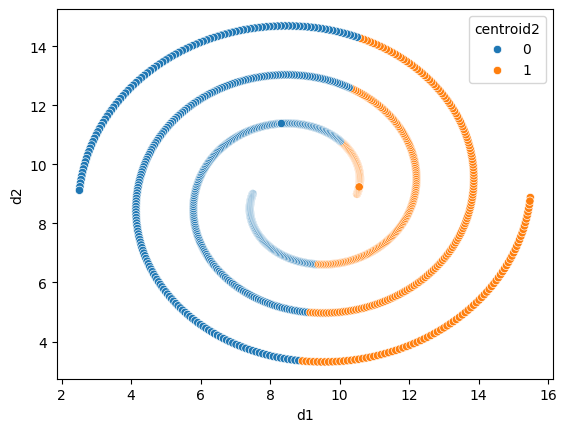

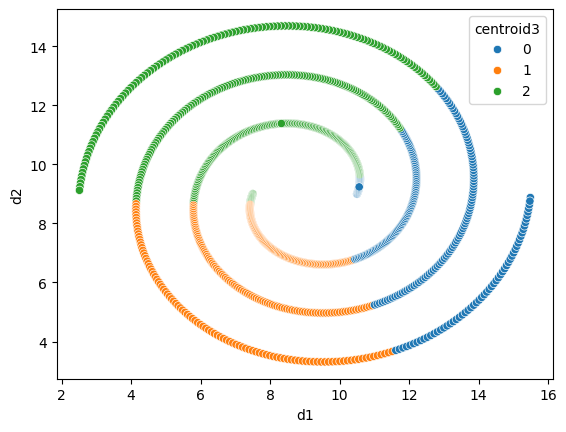

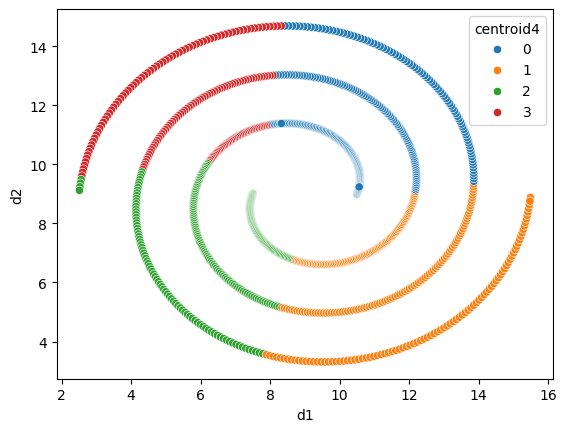

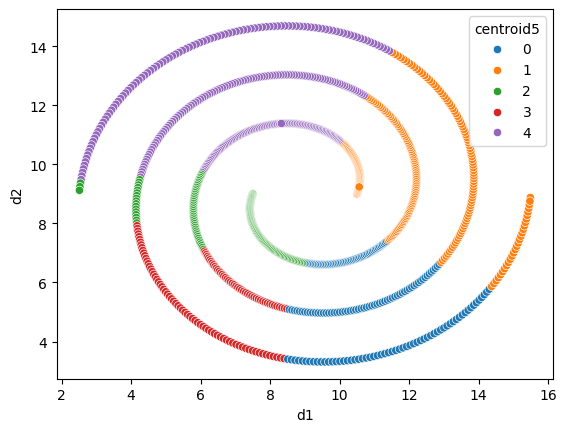

In [72]:
kmeans_plot(df1_kmeans,2,6)

Foram calculados os Índices para cada um dos diferentes números de clusters para cada um dos datasets fornecidos. A seguir, estão os Índices Rand para cada valor de k (2 a 5) com o dataset 'c2ds1-2sp'.

In [81]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_kmeans_spiral.csv")
print(tabulate(tabela.head(), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

╒═══════════════════════╤═════════════════════════╕
│   Quantidade_Clusters │    Indice_Rand_Ajustado │
╞═══════════════════════╪═════════════════════════╡
│                     2 │             0.000314928 │
├───────────────────────┼─────────────────────────┤
│                     3 │             0.0565137   │
├───────────────────────┼─────────────────────────┤
│                     4 │             0.0466712   │
├───────────────────────┼─────────────────────────┤
│                     5 │             0.0321402   │
╘═══════════════════════╧═════════════════════════╛


Observando apenas os índices obtidos acima, conseguimos perceber que os valores são muito próximos de zero, ou seja, esses agrupamentos são quase aleatórios, o que indica que o algoritmo K-Médias tem resultados insatisfatórios para o conjunto de dados fornecido. Essa visão é fortalecida ao analisar os gráficos gerados logo acima da tabela. Podemos apontar como causa disso, os clusters não terem uma forma esférica ou bem separada, assim, o k-médias pode ter dificuldades, já que ele assume que os clusters são aproximadamente circulares.

Desse modo, podemos dizer que esse tipo de distribuição não é ideal para o K-Médias.

Agora, vamos executar o K-Médias para o dataset 'c2ds3-2g'. Para esse conjunto de dados, os clusters (k) variam de 2 a 5.

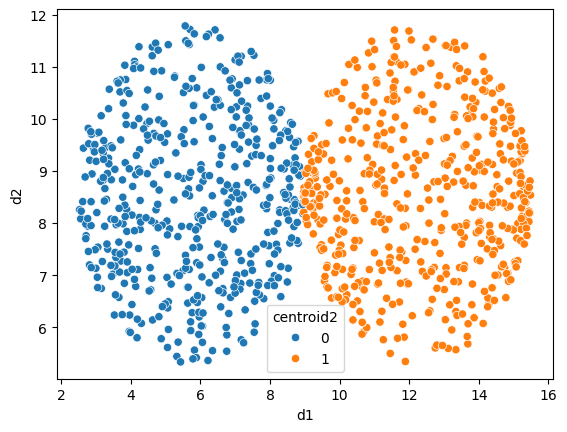

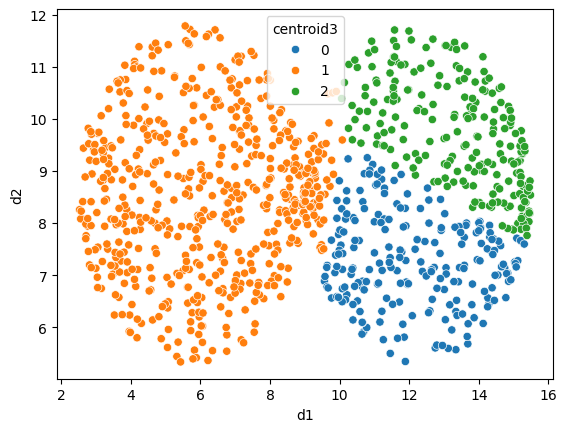

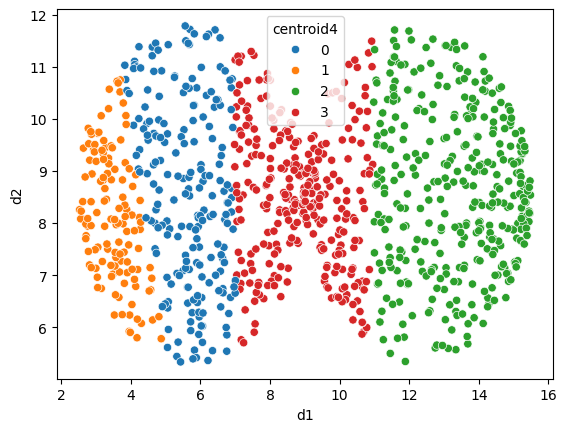

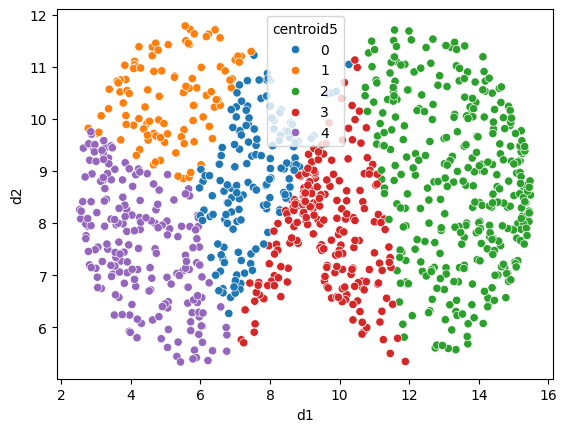

In [78]:
kmeans_plot(df0_kmeans,2,6)

A seguir, os Índices Rand para cada valor de k (2 a 5) com o dataset 'c2ds3-2g'.

In [82]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_kmeans_glob.csv")
print(tabulate(tabela.head(), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

╒═══════════════════════╤═════════════════════════╕
│   Quantidade_Clusters │    Indice_Rand_Ajustado │
╞═══════════════════════╪═════════════════════════╡
│                     2 │                0.968224 │
├───────────────────────┼─────────────────────────┤
│                     3 │                0.590927 │
├───────────────────────┼─────────────────────────┤
│                     4 │                0.378517 │
├───────────────────────┼─────────────────────────┤
│                     5 │                0.384141 │
╘═══════════════════════╧═════════════════════════╛


Para esse dataset, os resultados foram mais satisfatórios, já que os valores obtidos a partir do cáclulo do Índice Rand foram próximos de 1. Isso indica que as partições têm qualidade alta, em especial a partição referente a 2 clusters, que tem um índice quase perfeito, o que sugere que o conjunto de dados tem uma estrutura natural bem clara em 2 grupos. 
Podemos observar os gráficos gerados pelo algoritmo com essa entrada de dados, notando que os formatos estão mais organizados. Dessa forma, é coerente dizer que esse tipo de distribuição é ideal para o uso do K-Médias. 

Por fim, vamos executar o K-Médias para o dataset 'monkey'. Para esse conjunto de dados, os clusters (k) variam de 5 a 12.

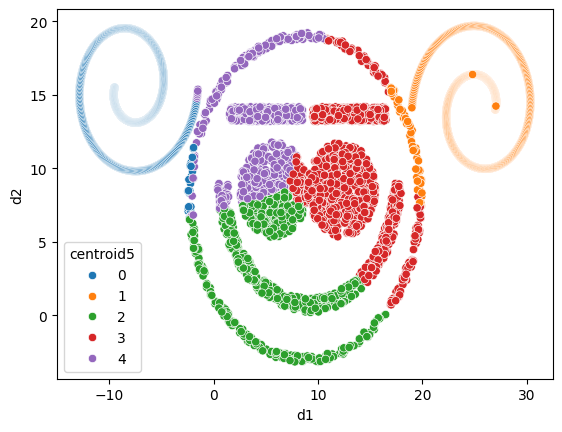

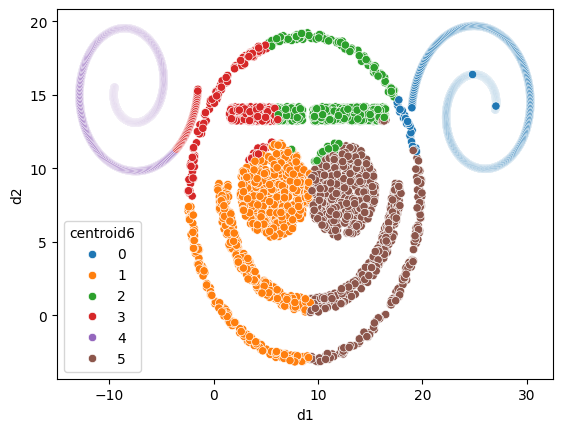

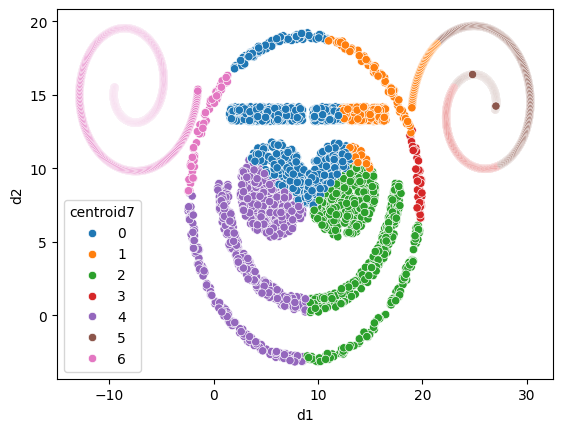

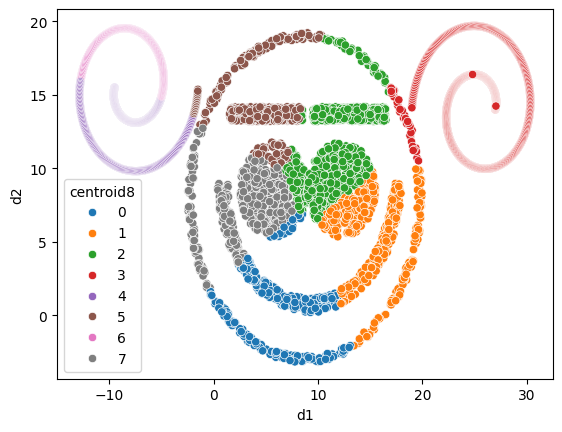

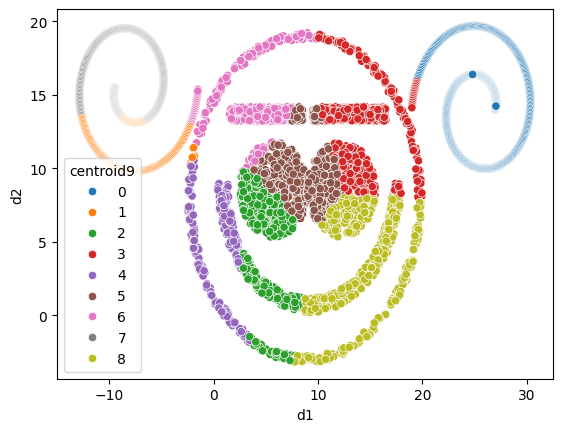

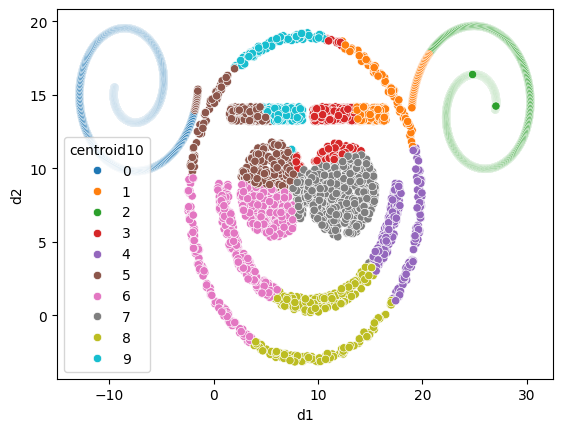

C:\Users\matte\AppData\Local\Temp\ipykernel_21084\3698423243.py:9: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["centroid" + str(i)], palette=cores)


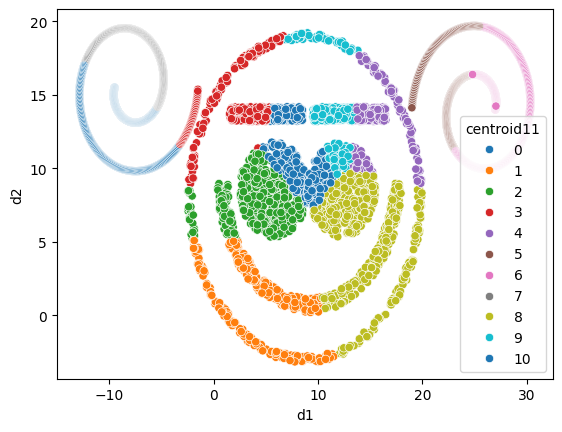

C:\Users\matte\AppData\Local\Temp\ipykernel_21084\3698423243.py:9: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["centroid" + str(i)], palette=cores)


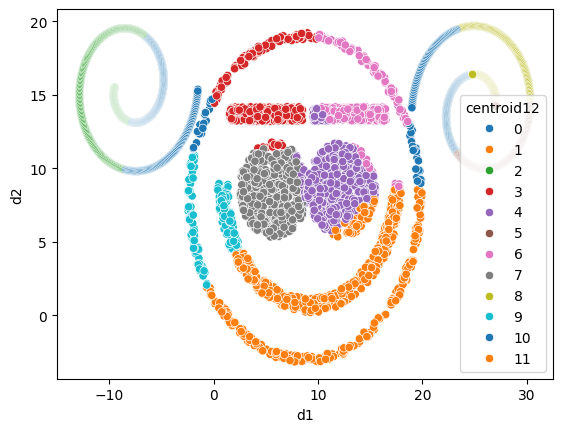

In [79]:
kmeans_plot(df2_kmeans,5,13)

A seguir, os Índices Rand para cada valor de k (5 a 12) com o dataset 'monkey'.

In [25]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_kmeans_monkee.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

╒═══════════════════════╤═════════════════════════╕
│   Quantidade_Clusters │    Indice_Rand_Ajustado │
╞═══════════════════════╪═════════════════════════╡
│                     5 │                0.44485  │
├───────────────────────┼─────────────────────────┤
│                     6 │                0.531842 │
├───────────────────────┼─────────────────────────┤
│                     7 │                0.390551 │
├───────────────────────┼─────────────────────────┤
│                     8 │                0.485101 │
├───────────────────────┼─────────────────────────┤
│                     9 │                0.463024 │
├───────────────────────┼─────────────────────────┤
│                    10 │                0.558326 │
├───────────────────────┼─────────────────────────┤
│                    11 │                0.38041  │
├───────────────────────┼─────────────────────────┤
│                    12 │                0.581562 │
╘═══════════════════════╧═════════════════════════╛


Esses valores de Índice Rand podem sugerir uma qualidade mediana a baixa das partições obtidas, já que os números calculados estão mais ao meio de 1. 
Ao analisar tanto a tabela quanto os gráficos gerados pelo algoritmo com o conjunto de dados 'monkey', notamos que a qualidade das partições melhora ao aumentar o número de clusters até certo ponto, mas há oscilações, indicando que o algoritmo pode estar introduzindo alguns clusters artificiais. Dessa forma, concluimos que a qualidade das partições é moderada.

Single-Link:

Como já citado antes, o algoritmo Single-Link é um método hierárquico de agrupamento que une os clusters mais próimos até que todos os pontos de dados estejam no mesmo cluster. Nesse algoritmo, a distância entre os dois cluster é definida pela menos distância entre qualquer par de pontos.
O Single-Link tende a funcionar bem com dados que apresentam uma estrutura de cadeia ou onde os grupos estão conectados por pequenas pontes de proximidade.

Foram calculados os Índices para cada um dos diferentes números de clusters para cada um dos datasets fornecidos.


Vamos começar apresentando e executando o Single-Link para o dataset 'c2ds1-2sp'. Para esse conjunto de dados, os clusters (k) variam de 2 a 5. 

In [ ]:
#chamar a função do single-link para c2ds1, variando o k entre 2 e 5#

A seguir, os Índices Rand para cada valor de k (2 a 5) com o dataset 'c2ds1-2sp'.

In [ ]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_singlelinkage_spiral.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

Assim, podemos ver que os valores do índice Rand foram perto/longe de 1, o que indica que o algoritmo tem resultados bons/ruins para o conjunto de dados fornecidos. Isso se fortalece ao observar os gráficos gerados pelo algoritmo acima. Desse modo, dizemos que esse tipo de distribuição (não)é ideal para o uso desse algoritmo de agrupamento. 

Agora, vamos executar o Single-Link para o dataset 'c2ds3-2g'. Para esse conjunto de dados, os clusters (k) variam de 2 a 5.


In [ ]:
#chamar a função do single-link para c2ds3, variando o k entre 2 e 5

A seguir, os Índices Rand para cada valor de k (2 a 5) com o dataset 'c2ds3-2g'.

In [ ]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_singlelinkage_glob.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

Assim, podemos ver que os valores do índice Rand foram perto/longe de 1, o que indica que o algoritmo tem resultados bons/ruins para o conjunto de dados fornecidos. Isso se fortalece ao observar os gráficos gerados pelo algoritmo acima. Desse modo, dizemos que esse tipo de distribuição (não)é ideal para o uso desse algoritmo de agrupamento. 

Por fim, vamos executar o Single-Link para o dataset 'monkey'. Para esse conjunto de dados, os clusters (k) variam de 5 a 12.

In [ ]:
#chamar função single-link para monkey, variando o k entre 5 e 12

A seguir, os Índices Rand para cada valor de k (5 a 12) com o dataset 'monkey'.

In [ ]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_singlelinkage_monkee.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

Assim, podemos ver que os valores do índice Rand foram perto/longe de 1, o que indica que o algoritmo tem resultados bons/ruins para o conjunto de dados fornecidos. Isso se fortalece ao observar os gráficos gerados pelo algoritmo acima. Desse modo, dizemos que esse tipo de distribuição (não)é ideal para o uso desse algoritmo de agrupamento. 



Complete-Link:

Foram calculados os Índices para cada um dos diferentes números de clusters para cada um dos datasets fornecidos.


Vamos começar apresentando e executando o Complete-Link para o dataset 'c2ds1-2sp'. Para esse conjunto de dados, os clusters (k) variam de 2 a 5. 

In [ ]:
#chamar a função do complete-link para c2ds1, variando o k entre 2 e 5

A seguir, os Índices Rand para cada valor de k (2 a 5) com o dataset 'c2ds1-2sp'.

In [ ]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_completelinkage_spiral.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

Assim, podemos ver que os valores do índice Rand foram perto/longe de 1, o que indica que o algoritmo tem resultados bons/ruins para o conjunto de dados fornecidos. Isso se fortalece ao observar os gráficos gerados pelo algoritmo acima. Desse modo, dizemos que esse tipo de distribuição (não)é ideal para o uso desse algoritmo de agrupamento. 

Agora, vamos executar o Complete-Link para o dataset 'c2ds3-2g'. Para esse conjunto de dados, os clusters (k) variam de 2 a 5.


In [ ]:
#chamar a função do single-link para c2ds3, variando o k entre 2 e 5

A seguir, os Índices Rand para cada valor de k (2 a 5) com o dataset 'c2ds3-2g'.

In [ ]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_completelinkage_glob.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)#

Assim, podemos ver que os valores do índice Rand foram perto/longe de 1, o que indica que o algoritmo tem resultados bons/ruins para o conjunto de dados fornecidos. Isso se fortalece ao observar os gráficos gerados pelo algoritmo acima. Desse modo, dizemos que esse tipo de distribuição (não)é ideal para o uso desse algoritmo de agrupamento. 

Por fim, vamos executar o Complete-Link para o dataset 'monkey'. Para esse conjunto de dados, os clusters (k) variam de 5 a 12.

In [ ]:
#chamar função complete-link para monkey, variando o k entre 5 e 12

A seguir, os Índices Rand para cada valor de k (5 a 12) com o dataset 'monkey'.

In [ ]:
from tabulate import tabulate
import pandas as pd

tabela = pd.read_csv("rand_completelinkage_monkee.csv")
print(tabulate(tabela.head(8), headers='keys', tablefmt='fancy_grid', showindex=False))
#print(tabela)

Assim, podemos ver que os valores do índice Rand foram perto/longe de 1, o que indica que o algoritmo tem resultados bons/ruins para o conjunto de dados fornecidos. Isso se fortalece ao observar os gráficos gerados pelo algoritmo acima. Desse modo, dizemos que esse tipo de distribuição (não)é ideal para o uso desse algoritmo de agrupamento. 

--- 
## Comparação com Notebook do roteiro 3
Após plotar todos os gráficos para cada um dos algoritmos e datasets, usando, também, o Índice Rand para avaliar a qualidade das partições obtidas pelo grupo, finalmente podemos comparar aquilo que obtivemos com as partições reais providas pelo arquivo Jupyter Notebook de título Algoritmos e Avaliação em Agrupamento, desenvolvido por Pedro Reis Pires
.
Aqui, iremos discutir e analisar as diferenças e semelhanças de cada conjunto de resultados obtidos.


---
## Conclusão

A intenção deste trabalho era desenvolver e ver na prática o comportamento dos algoritmos de agrupamento de acordo com os diferentes espalhamentos dos dados, além do funcionamento do Índice Rand Corrigido sobre cada divisão encontrada. A análise ocorreu sobre três arquivos em que um continha dados em espiral, outro, dados globulares e por fim um com várias formas geométricas diferentes.


Como esperado, o algoritmo K-Médias foi o melhor para lidar com dados que formavam formas geométricas globulares e não foi eficiente para gerar uma partição de qualidade para formas espirais. O arquivo com elementos globulares teve um ARI próximo a 1, o que é excelente, mas o espiral com 2 clusters alcançou um dos piores resultados de Índice Rand entre todas as partições. 


Por outro lado, as espirais foram muito bem identificadas no Single-Link. Esse algoritmo é ótimo para identificar clusters de aparência alongada e esférica mas não é bom em formas globulares. Ainda assim, de todos foi o que se saiu melhor no agrupamento dos dados do arquivo com formas variadas. Apesar de também ser um algoritmo hierárquico, o Complete-Link realmente se comportou diferente do Single-Link.


O Complete-Link é bem útil em encontrar clusters compactos e esféricos. Sua estratégia de usar a distância máxima entre qualquer par de pontos entre seus agrupamentos favorecem clusters que são bem separados, mas é falho com formas alongadas ou que se sobrepõem (justamente pela falta de separação espacial). Tal comportamento foi observado nos três arquivos.


Por fim, como se supunha, provou-se que não há um algoritmo melhor ou pior: sempre vai depender do conjunto de dados em questão. Cada algoritmo terá sua facilidade e dificuldade em encontrar clusters de acordo com o formato específico dos dados, e assim, ao escolher um algoritmo para clustering, é preciso levar em consideração os dados que estamos agrupando.


---
## Referencias Bibliográficas


* Carvalho, André Carlos Ponce de Leon Ferreira Et Al.. Inteligência Artificial - Uma Abordagem de Aprendizado de Máquina (Portuguese Edition). LTC. Edição do Kindle. 
* Pires, Pedro Reis. Algoritmos e Avaliação em Agrupamento. Notebook Jupiter.






